In [1]:
!git clone https://github.com/ayamohamdd/IP-25.git

fatal: destination path 'IP-25' already exists and is not an empty directory.


In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Input, Conv2DTranspose, Concatenate, Activation, Dropout
import os
import numpy as np
import matplotlib.pyplot as plt

# Input size and number of classes remain the same
input_size = (544, 960, 3)
num_of_classes = 8

# Color mapping remains the same
COLOR_MAPPING = {
    (0, 0, 0): 0,        # Background clutter
    (128, 0, 0): 1,      # Building
    (128, 64, 128): 2,   # Road
    (0, 128, 0): 3,      # Tree
    (128, 128, 0): 4,    # Low vegetation
    (64, 0, 128): 5,     # Moving car
    (192, 0, 192): 6,    # Static car
    (64, 64, 0): 7       # Human
}

CLASS_TO_COLOR = {v: k for k, v in COLOR_MAPPING.items()}

# Modified rgb_to_class function
def rgb_to_class(mask):
    height, width = mask.shape[0], mask.shape[1]
    mask_classes = np.zeros((height, width), dtype=np.int32)

    for color, class_idx in COLOR_MAPPING.items():
        # Create boolean mask for current color
        color_mask = np.all(mask == color, axis=-1)
        mask_classes[color_mask] = class_idx

    return mask_classes

# Modified load_and_preprocess_image function
def load_and_preprocess_image(image_path, mask_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [input_size[0], input_size[1]])
    image = image / 255.0

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, [input_size[0], input_size[1]], method='nearest')
    mask = tf.numpy_function(rgb_to_class, [mask], tf.int32)
    mask.set_shape([input_size[0], input_size[1]])

    return image, mask

# Rest of the model architecture and training code remains the same
def double_conv_block(inputs, num_filters, dropout_rate=0.1):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    return x
def conv_block(inputs, num_filters, dropout_rate=0.1):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    return x
def encoder_block(inputs, num_filters):
    x = double_conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2), padding='same')(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = double_conv_block(x, num_filters)
    return x

def build_segnet(input_shape, num_of_classes):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output layer
    outputs = Conv2D(num_of_classes, 1, padding="same", activation="softmax")(d4)

    return tf.keras.models.Model(inputs, outputs, name="SegNet")

def dice_coefficient(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, tf.int32)
    y_pred = K.cast(y_pred, tf.int32)
    intersection = K.sum(K.cast(y_true == y_pred, tf.float32))
    return 2 * intersection / (K.sum(K.cast(y_true, tf.float32)) + K.sum(K.cast(y_pred, tf.float32)))

def precision(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    true_positive = K.sum(K.cast((y_true == 1) & (y_pred == 1), tf.float32))
    false_positive = K.sum(K.cast((y_true == 0) & (y_pred == 1), tf.float32))
    return true_positive / (true_positive + false_positive + K.epsilon())

def recall(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    true_positive = K.sum(K.cast((y_true == 1) & (y_pred == 1), tf.float32))
    false_negative = K.sum(K.cast((y_true == 1) & (y_pred == 0), tf.float32))
    return true_positive / (true_positive + false_negative + K.epsilon())

def jaccard_index(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, tf.int32)
    y_pred = K.cast(y_pred, tf.int32)
    intersection = K.sum(K.cast(y_true == y_pred, tf.float32))
    union = K.sum(K.cast(y_true, tf.float32)) + K.sum(K.cast(y_pred, tf.float32)) - intersection
    return intersection / (union + K.epsilon())

def pixel_accuracy(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, tf.int32)
    y_pred = K.cast(y_pred, tf.int32)
    correct_pixels = K.sum(K.cast(y_true == y_pred, tf.float32))
    total_pixels = tf.cast(tf.size(y_true), tf.float32)
    return correct_pixels / total_pixels

# Data generator
def data_generator(image_list, mask_list, batch_size):
    num_samples = len(image_list)
    while True:
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_masks = []

            for idx in batch_indices:
                image, mask = load_and_preprocess_image(image_list[idx], mask_list[idx])
                batch_images.append(image)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)


# Dataset paths
train_image_path = '/content/IP-25/train_data/Images'
train_mask_path = '/content/IP-25/train_data/Labels'
val_image_path = '/content/IP-25/val_data/Images'
val_mask_path = '/content/IP-25/val_data/Labels'

train_image_list = sorted([os.path.join(train_image_path, i) for i in os.listdir(train_image_path)])
train_mask_list = sorted([os.path.join(train_mask_path, i) for i in os.listdir(train_mask_path)])
val_image_list = sorted([os.path.join(val_image_path, i) for i in os.listdir(val_image_path)])
val_mask_list = sorted([os.path.join(val_mask_path, i) for i in os.listdir(val_mask_path)])

# Training setup
batch_size = 8
train_steps_per_epoch = len(train_image_list) // batch_size
val_steps_per_epoch = len(val_image_list) // batch_size

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model2.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

segnet = build_segnet(input_size, num_of_classes)

segnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[pixel_accuracy, jaccard_index, dice_coefficient, precision, recall]
)

# Training the model
history = segnet.fit(
    data_generator(train_image_list, train_mask_list, batch_size),
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=data_generator(val_image_list, val_mask_list, batch_size),
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - dice_coefficient: 0.0524 - jaccard_index: 0.0270 - loss: 2.3233 - pixel_accuracy: 0.1586 - precision: 0.5628 - recall: 0.7506 - val_dice_coefficient: 0.1334 - val_jaccard_index: 0.0717 - val_loss: 1.9840 - val_pixel_accuracy: 0.2320 - val_precision: 0.6357 - val_recall: 0.2385 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - dice_coefficient: 0.1236 - jaccard_index: 0.0661 - loss: 1.8641 - pixel_accuracy: 0.3233 - precision: 0.6678 - recall: 0.8574 - val_dice_coefficient: 0.0681 - val_jaccard_index: 0.0353 - val_loss: 2.5190 - val_pixel_accuracy: 0.1730 - val_precision: 0.8510 - val_recall: 0.0056 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - dice_coefficient: 0.1997 - jaccard_index: 0.1111 - loss: 1.6515 - pixel_accuracy: 0.4435 - precision: 0.7536 - recall: 0.8757 - val_dice_coefficient: 0.1160 - val_jaccard_index: 0.0616 - val_loss: 2.0757 - val_pixel_accuracy: 0.20

In [4]:
segnet.save('segnet.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Visualization saved to: /content/predictions/prediction.png


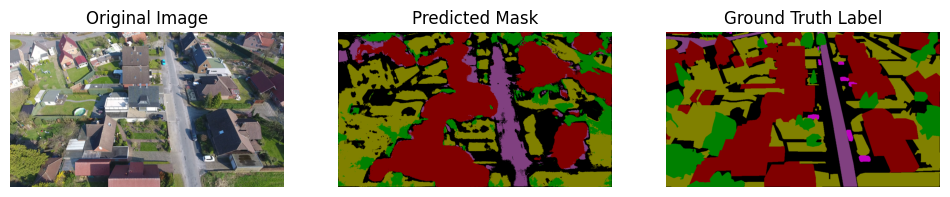

In [8]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define color mapping for visualization
COLOR_MAPPING = {
    0: (0, 0, 0),           # Background clutter
    1: (128, 0, 0),         # Building
    2: (128, 64, 128),      # Road
    3: (0, 128, 0),         # Tree
    4: (128, 128, 0),       # Low vegetation
    5: (64, 0, 128),        # Moving car
    6: (192, 0, 192),       # Static car
    7: (64, 64, 0),         # Human
}

def class_to_rgb(predicted_mask):
    """
    Convert class indices to RGB colors based on the defined color mapping.

    Args:
        predicted_mask (np.ndarray): 2D array of class indices.

    Returns:
        np.ndarray: 3D array of RGB colors.
    """
    colorized_image = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in COLOR_MAPPING.items():
        colorized_image[predicted_mask == class_idx] = color
    return colorized_image

def predict_and_visualize(image_path, mask_path, model, save_path=None):
    """
    Predict the segmentation mask for a single image and visualize the result.

    Args:
        image_path (str): Path to the input image.
        model (tf.keras.Model): Trained U-Net model.
        save_path (str, optional): Path to save the visualization. If None, it only displays the result.

    Returns:
        None
    """
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [input_size[0], input_size[1]])
    image = tf.clip_by_value(image / 255.0, 0, 1)
    input_image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Load and preprocess the true mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask)
    mask = tf.image.resize(mask, [input_size[0], input_size[1]], method='nearest')

    # Predict mask
    predicted_mask = tf.argmax(model.predict(input_image), axis=-1)
    predicted_mask = tf.squeeze(predicted_mask)  # Remove batch dimension

    # Convert class mask to RGB mask
    visual_mask = class_to_rgb(predicted_mask.numpy())  # Convert to numpy for visualization


    # Plot the original image and the predicted mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(visual_mask)
    plt.axis('off')

    # Plot the ground truth label image
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Label")
    plt.imshow(mask, cmap='tab20')  # Using a colormap for visualization
    plt.axis('off')

    # Save or display the visualization
    if save_path:
        # Ensure the directory exists
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path)
        print(f"Visualization saved to: {save_path}")
    else:
        plt.show()

# Example usage
image_path = '/content/IP-25/val_data/Images/seq36_000600.png'  # Replace with your image path
mask_path = '/content/IP-25/val_data/Labels/seq36_000600.png'  # Replace with your mask path
save_path = '/content/predictions/prediction.png'                 # Specify a valid save directory
predict_and_visualize(image_path,mask_path, segnet, save_path)